In [178]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

In [179]:
def load_frame(image_path: str, seconds: float) -> np.ndarray:
    cap = cv2.VideoCapture(image_path)
    cap.set(cv2.CAP_PROP_POS_MSEC, seconds * 1000)
    _, frame = cap.read()
    cap.release()
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

In [180]:
frame1 = load_frame("../data/raw/train/00325.mp4", 19)
frame2 = load_frame("../data/raw/train/00325.mp4", 19.1)

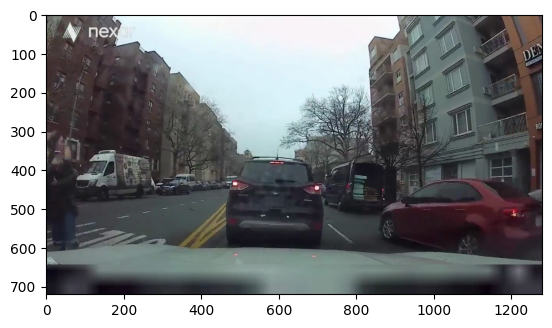

In [181]:
plt.imshow(frame1)
plt.show()

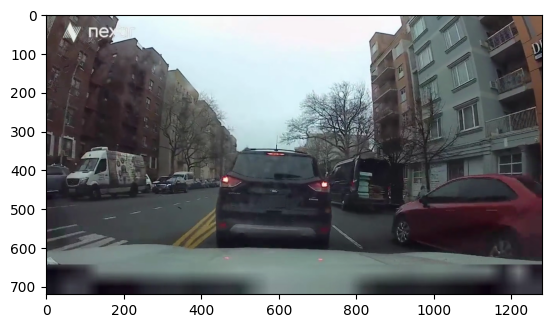

In [182]:
plt.imshow(frame2)
plt.show()


0: 384x640 1 person, 5 cars, 2 trucks, 1 traffic light, 197.9ms
Speed: 4.3ms preprocess, 197.9ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)


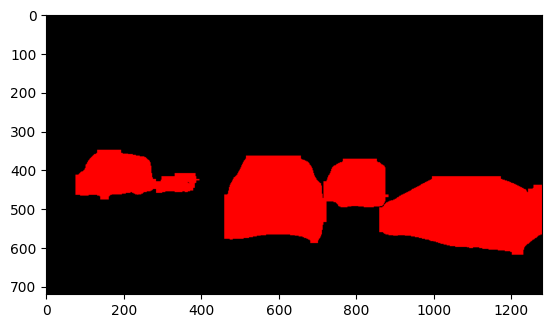

In [184]:
model = YOLO("yolov8m-seg.pt")
vehicle_classes = {'car', 'truck', 'bus', 'motorbike', 'bicycle'}


results = model(frame1)[0]

mask_out = np.zeros((frame1.shape[0], frame1.shape[1]), dtype=np.uint8)
for seg, cls_id in zip(results.masks.data, results.boxes.cls):
    class_name = model.model.names[int(cls_id)]
    if class_name in vehicle_classes:
        mask = cv2.resize(seg.numpy().astype(np.uint8), (frame1.shape[1], frame1.shape[0]), interpolation=cv2.INTER_NEAREST)
        mask_out[mask > 0] = 255
        mask_out = np.maximum(mask_out, mask)

# Plot mask_out as red with black background
plot_mask = np.zeros((frame1.shape[0], frame1.shape[1], 3), dtype=np.uint8)
plot_mask[mask_out > 0] = [255, 0, 0]  # Red color for mask
plt.imshow(plot_mask)
plt.show()

In [185]:
def compute_flow_channels(frame1: np.ndarray, frame2: np.ndarray) -> np.ndarray:
    # Convert to grayscale
    prev_gray = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
    next_gray = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

    # Compute Dense Optical Flow (Farneback)
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0
    )

    # Compute magnitude and direction
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Normalize magnitude and angle
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    angle = (angle * 180 / np.pi / 2).astype(np.uint8)

    # Stack into a single 2-channel image
    flow_channels = np.dstack((magnitude, angle))

    return flow_channels

flow_channels = compute_flow_channels(frame1, frame2)

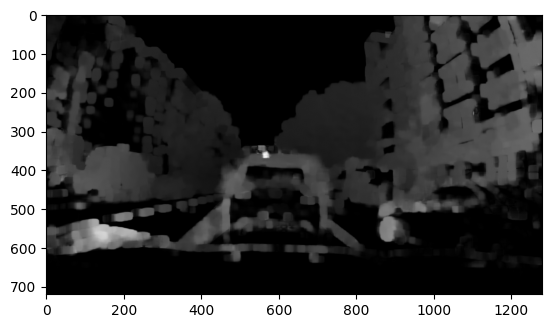

In [186]:
plt.imshow(flow_channels[..., 0], cmap='gray')
plt.show()

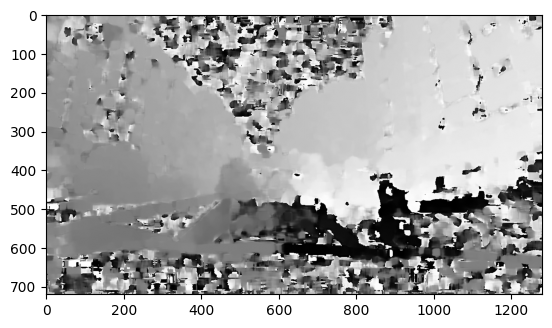

In [187]:
plt.imshow(flow_channels[..., 1], cmap='gray')
plt.show()

In [188]:
def plot_optical_flow_field(frame: np.ndarray, flow_channels: np.ndarray, step: int = 10):
    """
    Draws an optical flow field on the original frame.

    Parameters:
        frame (np.ndarray): Original image (grayscale or BGR).
        flow_channels (np.ndarray): Optical flow image (H, W, 2), with [magnitude, angle in degrees].
        step (int): Sampling step size to reduce clutter (default=10).
    """
    # Convert grayscale to 3-channel with red intensity only
    if len(frame.shape) == 2 or frame.shape[2] == 1:
        red_channel = frame if len(frame.shape) == 2 else frame[:, :, 0]
        zeros = np.zeros_like(red_channel)
        frame_with_arrows = cv2.merge([zeros, zeros, red_channel])  # B, G, R
    else:
        frame_with_arrows = frame.copy()

    arrow_color = (0, 255, 0)  # Green

    h, w = flow_channels.shape[:2]

    for y in range(0, h, step):
        for x in range(0, w, step):
            magnitude = flow_channels[y, x, 0]
            angle_deg = flow_channels[y, x, 1]
            angle_rad = angle_deg * 2 * np.pi / 180  # Convert to radians

            dx = int(magnitude * np.cos(angle_rad))
            dy = int(magnitude * np.sin(angle_rad))

            start_point = (x, y)
            end_point = (x + dx, y + dy)

            if magnitude > 1:
                cv2.arrowedLine(frame_with_arrows, start_point, end_point, arrow_color, 1, tipLength=0.3)

    # plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(frame_with_arrows, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
mask_expanded = mask_out[..., np.newaxis]
masked_frame2 = frame2 * (mask_expanded > 0)
masked_flows = flow_channels * (mask_expanded > 0)

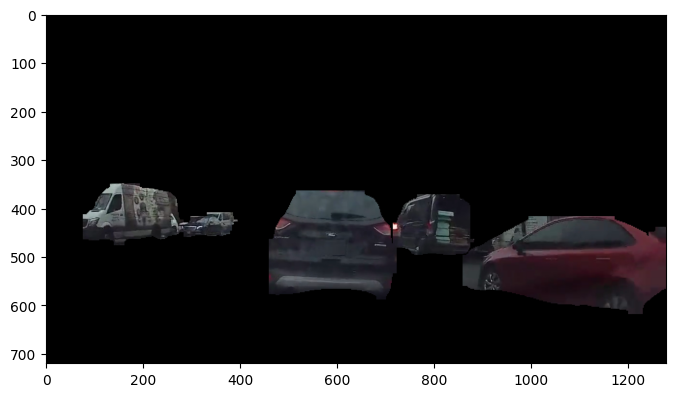

In [190]:
plt.figure(figsize=(8, 8))
plt.imshow(masked_frame2)
plt.show()

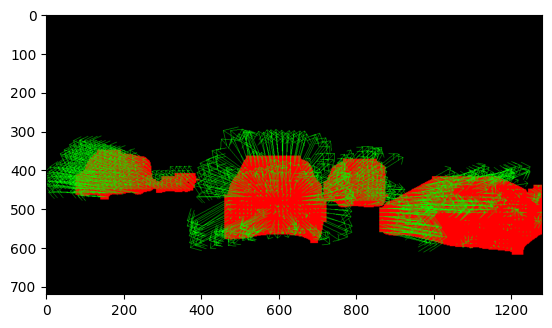

In [191]:
plot_optical_flow_field(
    mask_out,
    masked_flows,
    step=10,
)